# Coronory Artery Disease Project
## Exploratory analysis
### Prediction of heart disease given 14 variables

For this analysis we use the Cleveland "Coronary Artery Disease" dataset found on the UCI Machine Learning Repository
at the following location:

<a href=https://archive.ics.uci.edu/ml/datasets/Heart+Disease>Heart Disease Dataset</a>

The objective of the analysis is to use statistical learning to identify factors associated with Coronary Artery
Disease as indicated by a coronary angiography interpreted by a Cardiologist.

According to the paper by (Detrano et al., 1989) the data represents data collected for 303 patients referred for
coronary angiography at the Cleveland Clinic between May 1981 and September 1984. The 13 independent/ features
variables can be divided into 3 groups as follows:

Routine evaluation (based on historical data):
* ECG at rest
* Serum Cholesterol
* Fasting blood sugar

Non-invasive test data (informed consent obtained for data as part of research protocol):
* Exercise ECG
    * ST-segment peak slope (upsloping, flat or downsloping)
    * ST-segment depression
* Excercise Thallium scintigraphy (fixed, reversible or none)
* Cardiac fluoroscopy (number of vessels appeared to contain calcium)

Other demographic and clinical variables (based on routine data):
* Age
* Sex
* Chest pain type
* Systolic blood pressure
* ST-T-wave abnormality (T-wave abnormality)
* Probably or definite ventricular hypertrophy (Este's criteria)

The dependent/ response variable was the angiographic test result indicating a >50% diameter narrowing.

Detrano et al created 352 logistic regression models based on different combinations of the previously discussed
13 variables. Depending on information available in the test dataset one of these models was applied during model
validation.

Unfortunately the the paper by (Detrano et al., 1989) does not publish extensive model accuracy results such as:
overall accuracy, C-Statistic, precision (positive predictive value), recall (sensitivity) or specificity. The
model was however validated on various external datasets which is very important. The positive predictive value is
reported for a range of probability cut-off points for the various test sets.

From these results one can see that the model was capable of a Precision of approximately 80% for datasets closely
matching the Cleveland dataset in terms of disease prevalence within the test set.

We are going to replicate the analysis by performing a logistic regression and will perform a validation study to
confirm results obtained by (Detrano et al., 1989) in terms of model accuracy. Furthermore we will do an analysis of
significance of the various logistic regression features as means of classifying feature importance.

Subsequent to this analysis we will use an ensemble model to create feature importance classifications for a variety
of ML techniques to validate the regression findings.

We aim to achieve this by following the Machine Learning pipeline approach of deploying a variety of ML techniques to
build a predictive model and analyse its results. In the process we hope to gain valuable insights. The various steps
in the process are as follows (not necessarily in this order):

- Load data
- Prepare data
    - Clean data
        - Missing values
        - Outliers
        - Erroneous values
    - Explore data
        - Exploratory descriptive analysis (EDA)
        - Correlation analysis
        - Variable cluster analysis
    - Transform Data
        - Engineer features
        - Encode data
        - Scale & normalise data
        - Impute data
        - Feature selection/ importance analysis
- Build model
    - Model selection
    - Data sampling (validation strategy, imbalanced classification)
    - Hyperparameter optimisation
- Validate model
    - Accuracy testing
- Analysis of results
    - Response curves
    - Accuracy analysis
    - Commentary

Let us start the analysis!

In [36]:
%load_ext autoreload
%autoreload 2

# Import libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from src.visualization.visualize import plot_confusion_matrix, plot_roc_curve, plot_feature_importance, plot_feature_importance_log
from sklearn.feature_selection import RFE
import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div class="alert alert-block alert-info">
<b>Load data</b>
</div>

In [37]:
# Import data
df = pd.read_csv('../data/raw/processed.cleveland.data', header = None, names = ['age', 'sex', 'chest_pain_type', 'trestbps', 'col',
                'fasting_blood_sugar', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'], index_col=None,
                 usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], sep=',', skipinitialspace=True)
df.head(20)
print(df.shape)

,age,sex,cp,trestbps,col,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0
8,63.0,1.0,4.0,130.0,254.0,0.0,2.0,147.0,0.0,1.4,2.0,1.0,7.0,2
9,53.0,1.0,4.0,140.0,203.0,1.0,2.0,155.0,1.0,3.1,3.0,0.0,7.0,1


(303, 14)


The dataset read from csv file has 303 rows and 14 columns.
The data dictionary specified that 303 rows and 75 columns existed.
We therefore have the same number of rows as the data dictionary, but 61 fewer columns...

We were lucky that the data was already pre-processed, and this can be observed from the subset of data displayed
appearing very clean. Hopefully not much further cleaning would be required.

We created a data dictionary for the data is as follows:

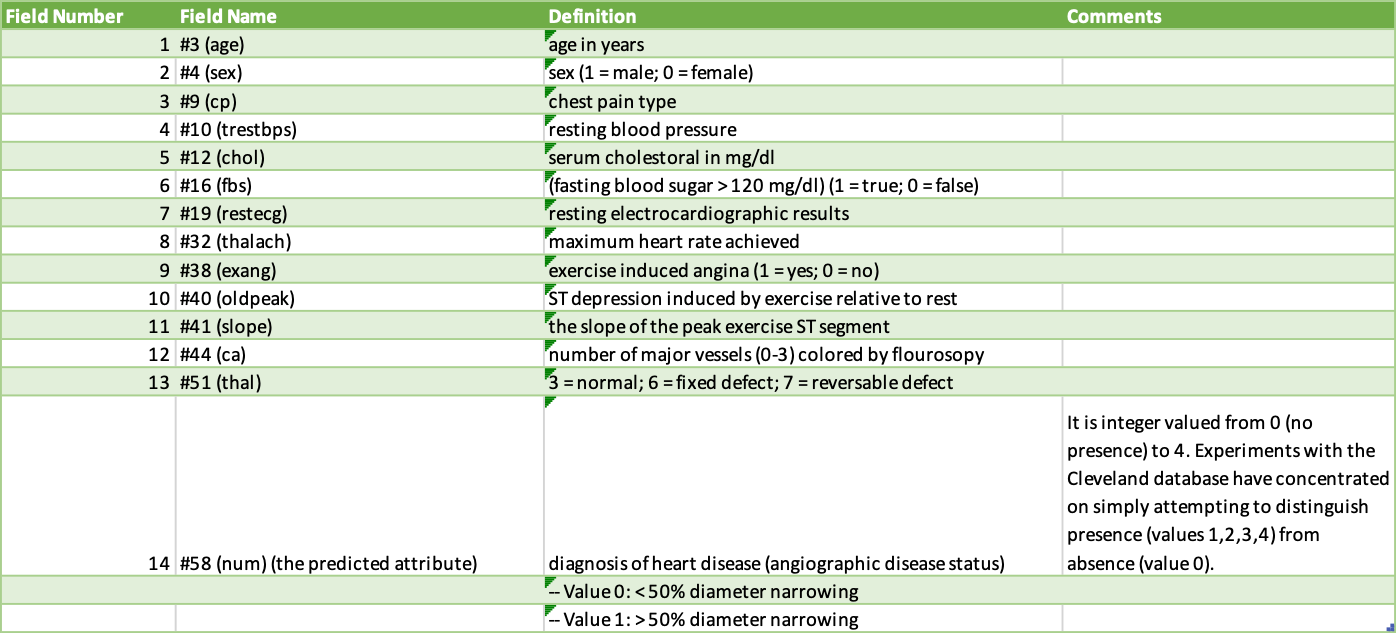

Let us explore the data!

<div class="alert alert-block alert-info">
<b>Clean data</b>
</div>

In [38]:
# Type of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   col       303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
None


From the output we observe that we have twelve numeric columns and two "object" columns. The data dictionary
however specifies that all fields are numeric. This means that Python could not convert two numeric variables
(ca and thal) to numeric columns due to their contents being non-numeric. Let us investigate.

In [39]:
# Find out what types of data is stored in object column. Use simple regex. Leading number omitted not catered for.
# Future improvement.
r = re.compile(r'\d+[.,]\d*')
df.ca.apply(lambda x: bool(r.match(x))).value_counts()
df.thal.apply(lambda x: bool(r.match(x))).value_counts()

df.loc[df.ca.apply(lambda x: bool(r.match(x))) == False]
df.loc[df.thal.apply(lambda x: bool(r.match(x))) == False]

True     299
False      4
Name: ca, dtype: int64

True     301
False      2
Name: thal, dtype: int64

,age,sex,cp,trestbps,col,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


,age,sex,cp,trestbps,col,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2


We can see that there are 4 non-numeric fields in ca and 2 in thal. These values are all '?'. It is a reasonable
assumption that these are missing values from data entry due to the placeholder. We will therefore clean the data by
replacing these values with NaN and converting all character values to decimal.

In [40]:
# Replace all non numeric data with NaN, convert strings to numbers.
df_clean = df.apply(pd.to_numeric, errors='coerce')

Let us see if that worked! We should now have only decimal and null values.

In [41]:
# Number of null values
print(df_clean.isnull().sum())

# Actual null values
df_clean[df_clean.isnull().any(axis=1)]


age         0
sex         0
cp          0
trestbps    0
col         0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


,age,sex,cp,trestbps,col,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,NaN,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,NaN,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,NaN,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,NaN,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,NaN,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


Looks great we have 6 null values, 4 in ca and 2 in thal as expected.  We can also observe that none of the other
fields contain any null values.

Seeing as there are only a handful of these values and none in the response variable, it is not necessary to remove
these records from the dataset at this stage.

We now have a dataset with 303 records and 14 numeric fields, as per the data dictionary, there are still 6 missing
values in the 'ca' and 'thal' fields though. Due to the low number of missing values and even distribution of values in
these fields (see explore analysis below) we will now substitute these with median values.

In [42]:
df_fin = df_clean.copy()
median = df_fin['ca'].median()
df_fin['ca'].fillna(median, inplace=True)
print("Number of null values in ca column: {}".format(df_fin['ca'].isnull().sum()))

median = df_fin['thal'].median()
df_fin['thal'].fillna(median, inplace=True)
print("Number of null values in thal column: {}".format(df_fin['thal'].isnull().sum()))
print("Dataframe dimension: {}".format(df_fin.shape))

Number of null values in ca column: 0
Number of null values in thal column: 0
Dataframe dimension: (303, 14)


Now our set is finally ready for further analysis. We will now look at the distribution of variables and any possible
outliers or heavy tailed distributions.

<div class="alert alert-block alert-info">
<b>Explore data</b>
</div>

We start by looking at the number of unique records per variable.

In [43]:
print(df_fin.nunique())

age          41
sex           2
cp            4
trestbps     50
col         152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            4
thal          3
num           5
dtype: int64


There are no columns with only one value. We therefore retain all columns for ML purposes as there is enough
variability to warrant using the data. Interesting to observe that there is also a fair amount of similarity in
the cholesterol measurements which is surprising. There are many variables with fewer than 10 levels which
could be considered as categorical. Based on our initial assessment of the data we will work with levels of measurement
for the data as follows:

- age (continuous)
- sex (binary)
- chest_pain_type (ordinal)
- trestbps (continuous)
- chol (continuous)
- fasting_blood_sugar (binary)
- restecg (ordinal)
- thalach (continuous)
- exang (binary)
- oldpeak (continuous)
- slope (ordinal)
- ca (ordinal)
- thal (ordinal - needs reordering)
- num (binary - we will need to transform as there are actually 5 levels in the data)

At this point it seems as if the only nominal data is binary, which means we might not need any One Hot Encoding
initially. We will leave the ordinal data as is for the initial analysis.
Next we look at the distribution of the data.

We now extract data according levels of measurement first to ease analysis. We also rename the variables to enable
ease of interpretion.

In [44]:
# Extract categorical variables for analysis.
df_fin_cat = df_fin.copy()
names_cat = ('sex', 'chest_pain_type', 'fasting_blood_sugar', 'restecg', 'exang', 'slope', 'ca', 'thal', 'num')
df_fin_cat = df_fin_cat.loc[:, names_cat]

dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Extract continuous variables for analysis.
#df_fin.reset_index(drop=True, inplace=True)
df_fin_con = df_fin.copy()
names_con = ('age', 'trestbps', 'col', 'thalach', 'oldpeak')
df_fin_con = df_fin_con.loc[:, names_con]

# Extract numeric variables for analysis.
df_fin.reset_index(drop=True, inplace=True)
df_fin_num = df_fin.copy()
names_num = ('age', 'sex', 'chest_pain_type', 'trestbps', 'col', 'fasting_blood_sugar', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal',
         'num')
df_fin_num = df_fin_num.loc[:, names_num]

Now let us consider the response variable.

0    164
1     55
2     36
3     35
4     13
Name: num, dtype: int64


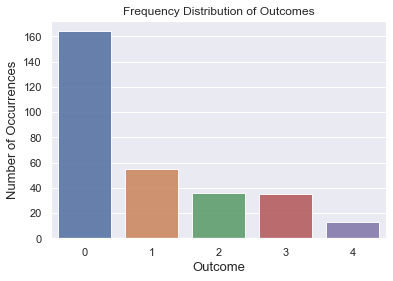

In [45]:
#outcome_counts = df_fin_cat.groupby('num').size()
outcome_counts = df_fin_cat['num'].value_counts()
print(outcome_counts)

# Plot outcome counts.
sns.set(font_scale=1);
sns.barplot(x=outcome_counts.index, y=outcome_counts.values, alpha=0.9)
plt.title('Frequency Distribution of Outcomes')
plt.ylabel('Number of Occurrences', fontsize=13)
plt.xlabel('Outcome', fontsize=13)
plt.show();

All looks good here. No obvious issues with the data. The spread of the data is good for classification, as there are
a large number of positive cases. If one combines classes 1, 2, 3 and 4 as suggested there will be a fairly even split
between positive and negative outcomes.
Let us look at that.

0    164
1    139
Name: num_bin, dtype: int64


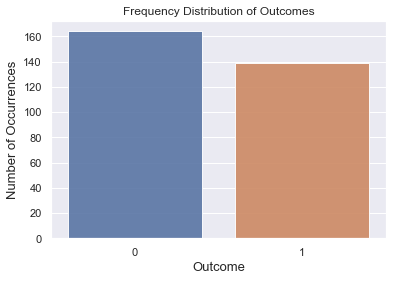

In [46]:
# Transform y variable
df_fin_cat['num_bin'] = df_fin['num'].apply(lambda x: 1 if x > 0 else 0)

outcome_counts_bin = df_fin_cat['num_bin'].value_counts()
print(outcome_counts_bin)
sns.set(font_scale=1);
ax = sns.barplot(x=outcome_counts_bin.index, y=outcome_counts_bin.values, alpha=0.9)
plt.title('Frequency Distribution of Outcomes')
plt.ylabel('Number of Occurrences', fontsize=13)
plt.xlabel('Outcome', fontsize=13)
plt.show();

As expected, we don't need to be concerned about imbalanced classes for this analysis.

Let us now consider the categorical variables.

In [47]:
# Class level counts for categorical variables.
for variable in names_cat:
    print(df_fin_cat[variable].value_counts())

1.0    206
0.0     97
Name: sex, dtype: int64
4.0    144
3.0     86
2.0     50
1.0     23
Name: cp, dtype: int64
0.0    258
1.0     45
Name: fbs, dtype: int64
0.0    151
2.0    148
1.0      4
Name: restecg, dtype: int64
0.0    204
1.0     99
Name: exang, dtype: int64
1.0    142
2.0    140
3.0     21
Name: slope, dtype: int64
0.0    180
1.0     65
2.0     38
3.0     20
Name: ca, dtype: int64
3.0    168
7.0    117
6.0     18
Name: thal, dtype: int64
0    164
1     55
2     36
3     35
4     13
Name: num, dtype: int64


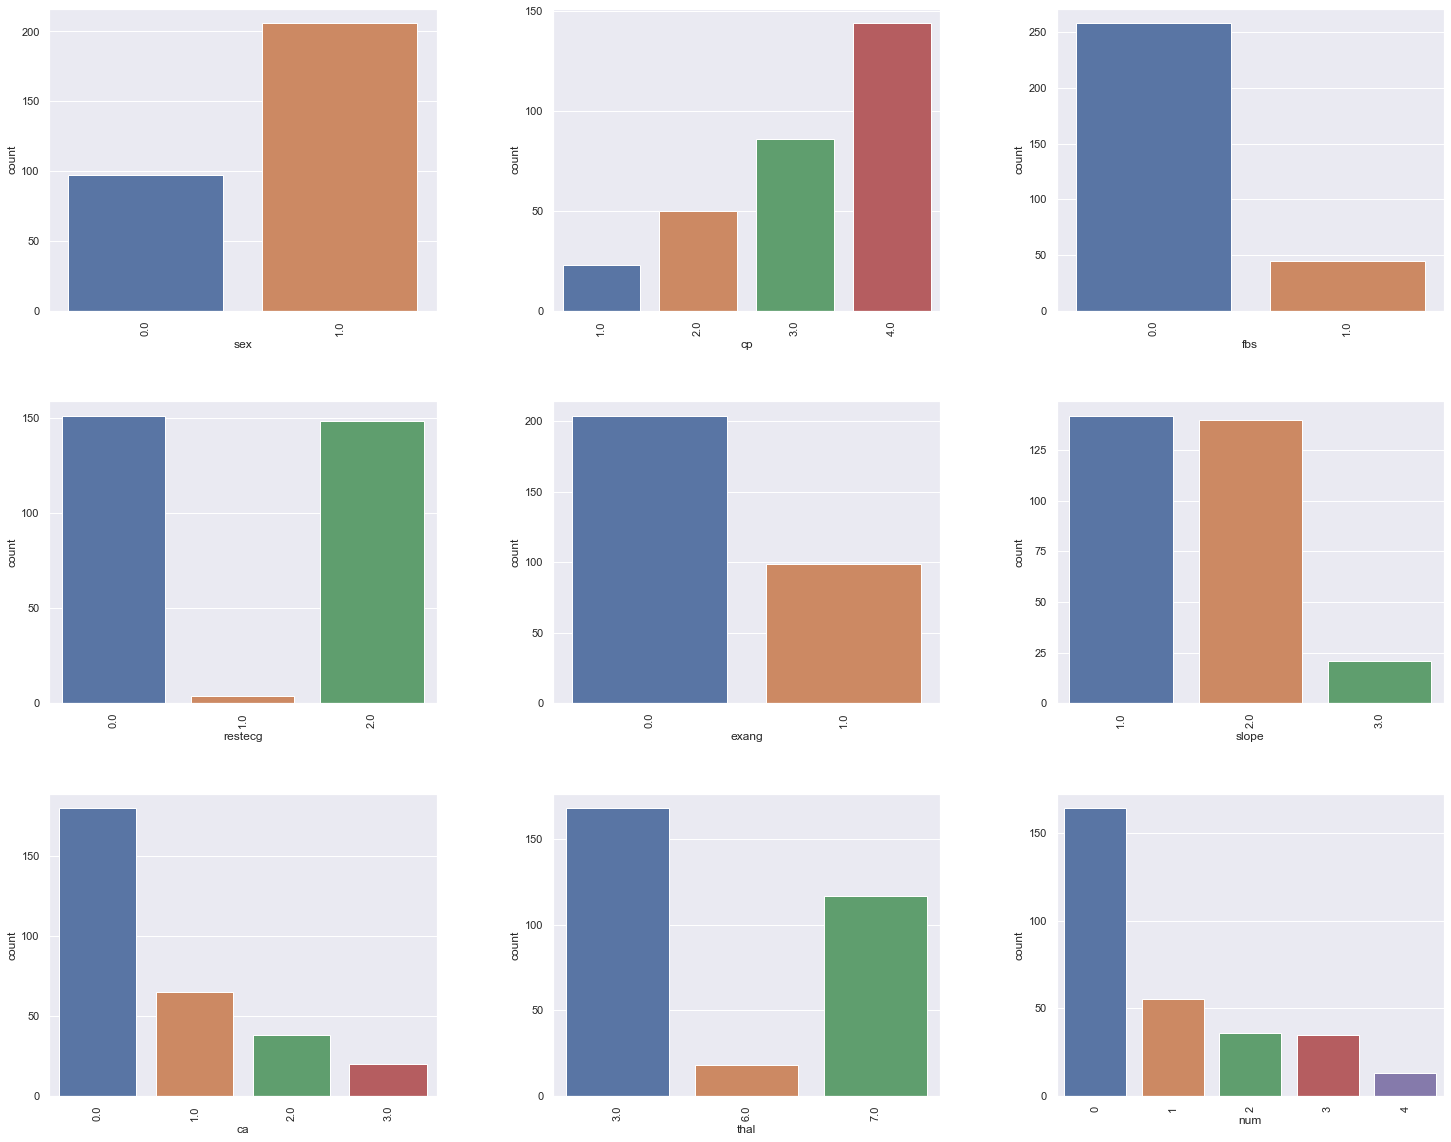

In [48]:
# Bar chart plot of categorical variables.
fig, ax = plt.subplots(3, 3, figsize=(25, 20));
sns.set(font_scale=2);
#sns.set(style="darkgrid")
fig.subplots_adjust(hspace=0.3, wspace=0.3);
for variable, subplot in zip(names_cat, ax.flatten()):
    _ = sns.countplot(x=df_fin_cat[variable], ax=subplot);
    for label in subplot.get_xticklabels():
        label.set_rotation(90);


The data looks fine from a modelling perspective, apart from the fact that the 'thal' variable needs to be recoded.
The values are not coded in the correct order.

Next, let us consider the continuous variables.

In [49]:
# 5 number summary.
df_fin_con.describe()

,age,trestbps,col,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604
std,9.038662,17.599748,51.776918,22.875003,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000
75%,61.000000,140.000000,275.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


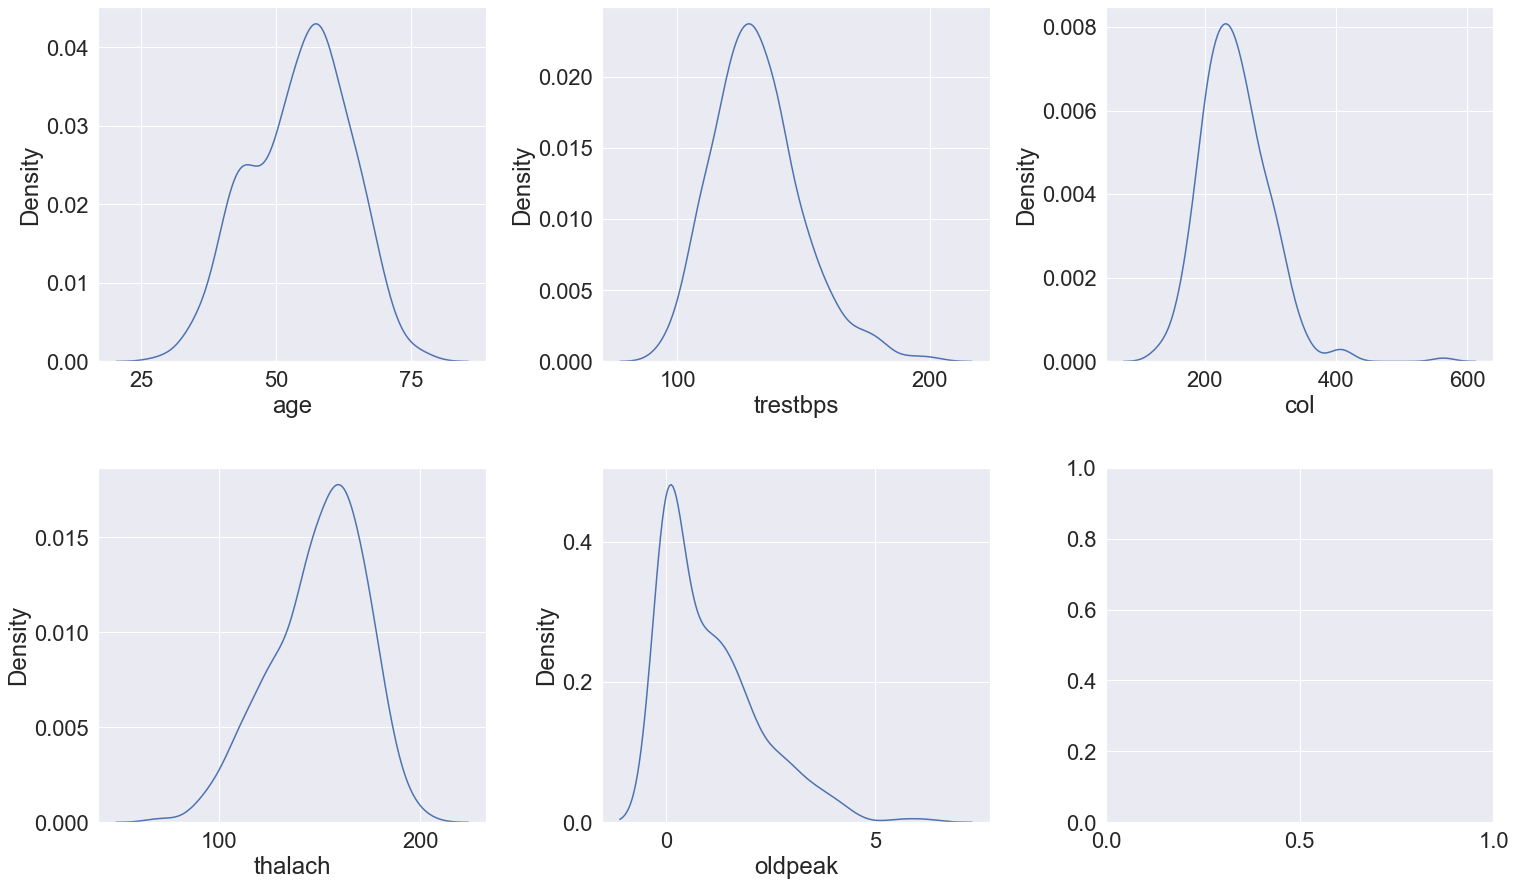

In [50]:
# Continuous density plot
fig, ax = plt.subplots(2, 3, figsize=(25, 15));
sns.set(font_scale=3);
fig.subplots_adjust(hspace=0.3, wspace=0.3);
for variable, subplot in zip(names_con, ax.flatten()):
    if variable:
        _ = sns.kdeplot(x=df_fin_con[variable], ax=subplot);
    else:
        subplot.close(5) # close current figure just created by catplot
        subplot.set_axis_off() # h

plt.show();

In [51]:
for variable in names_con:
    skew = df_fin_con[variable].skew()
    print("Skewness value for {}: {}".format(variable, skew))


Skewness value for age: -0.20906046882012877
Skewness value for trestbps: 0.7060346498131783
Skewness value for col: 1.1355031533363453
Skewness value for thalach: -0.5374486699106463
Skewness value for oldpeak: 1.2697199306019966


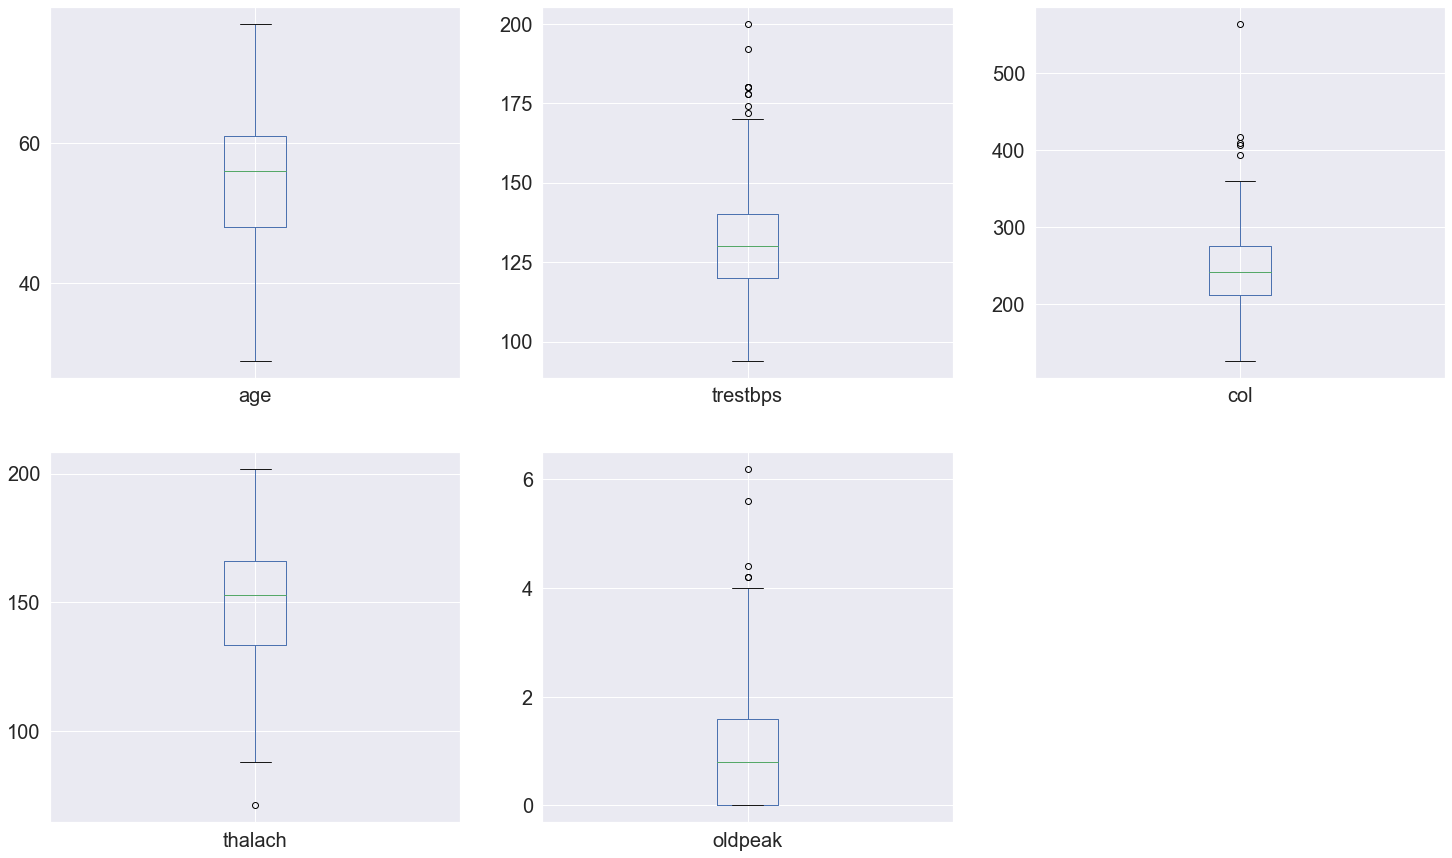

In [52]:
# Boxplot of continuous variables
df_fin_con.plot(kind='box', subplots=True, figsize=(25, 15), layout=(2,3), fontsize = 20, sharex=False)
fig.subplots_adjust(hspace=0.6, wspace=0.6);
plt.show();

No surprises here with regards to the continuous feature variables. We are dealing with an older population here with
average age of 54 years old. There are a few outliers for high resting blood pressure with the distribution showing
a slight skew to the right. Likewise for col and oldpeak, with these two showing even higher skewness. Conversely
talach has outliers to left and slight skewness to left too. This makes sense, as higher values for the prior would
indicate poorer health, whereas lower values for talach would indicate poorer health.

The distributions of the feature variables have varying scales, so standardisation would be required for ML purposes.
Seeing as we will not be running a regression, normalisation would not be required. Investigation into outliers is
recommended as it might reveal interesting facts and would improve the model performance if outliers were addressed.


<div class="alert alert-block alert-info">
<b>Build Naive Model - Baseline</b>
</div>

We start by splitting the response and the features.

In [53]:
# Transform y variable
df_fin['num'] = df_fin['num'].apply(lambda x: 1 if x > 0 else 0)

# Copy original dataset
df_fin_nn = df_fin.copy()

# Group response values to form binary response
y = df_fin_nn.loc[:, 'num']

# Split data into features (X) and response (y)
X = df_fin_nn.loc[:, ('age', 'sex', 'chest_pain_type', 'trestbps', 'col', 'fasting_blood_sugar', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
                   'ca', 'thal')]

X.head()

# Put the response y into an array
y = np.ravel(y)

,age,sex,cp,trestbps,col,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


Split the data into training and test sets

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [55]:
print('Percentage holdout data: {}%'.format(round(100*(len(X_test)/len(X)),0)))

Percentage holdout data: 25.0%


We now build and test a naive logistic regression model - without any transformations or optimisations.

AUC: 0.8673611111111111


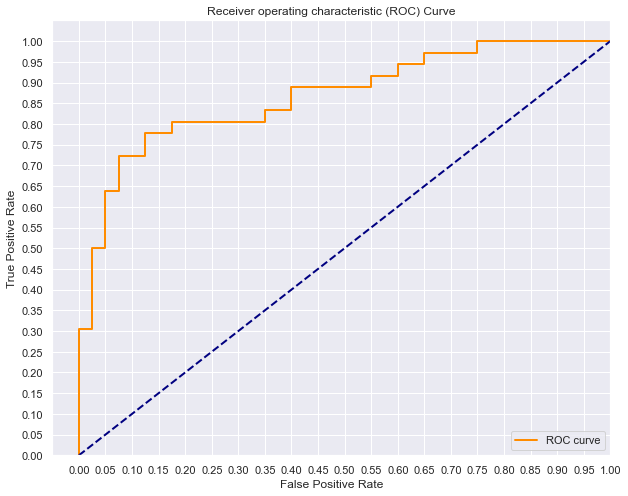

In [56]:
# Initial model
logreg = LogisticRegression(max_iter=2000000, fit_intercept = False)

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_score)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

Normalized confusion matrix

accuracy:			0.825  
precision:			0.799 
recall:				0.867

specificity:			0.783 
negative predictive value:	0.854

false positive rate:		0.217  
false negative rate:		0.133 
false discovery rate:		0.201


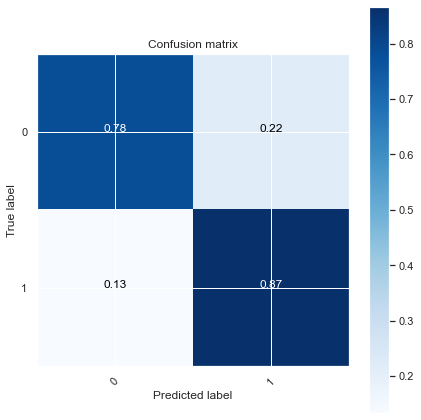

In [57]:
y_pred = logreg.predict(X_test)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

<div class="alert alert-block alert-info">
<b>Build Logistic Regression - Release 1</b>
</div>


Scale and transform variables

In [58]:
# Transform thal variable
trans_thal = {3:0, 7:1, 6:2}
df_fin_nn = df_fin.replace({"thal": trans_thal})

# Re-extract transformed X features
X = df_fin_nn.loc[:, ('age', 'sex', 'chest_pain_type', 'trestbps', 'col', 'fasting_blood_sugar', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
                   'ca', 'thal')]

# Rebuild training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scale data
scaler = StandardScaler()

# Fit on training data set
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Apply to test data
X_test = scaler.transform(X_test)


StandardScaler()

We now build a logistic regression model with data scaled and transformed according to Exploratory Data Analysis
results.

AUC: 0.8770833333333333


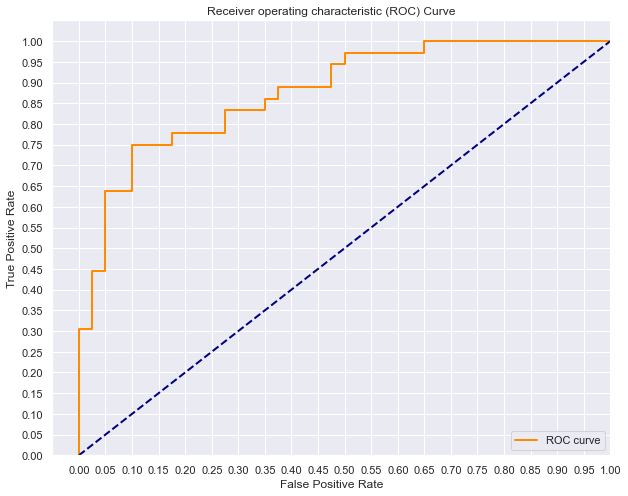

In [59]:
# Initial model
logreg = LogisticRegression(fit_intercept = False)

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test, y_score)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

Normalized confusion matrix

accuracy:			0.82  
precision:			0.805 
recall:				0.844

specificity:			0.795 
negative predictive value:	0.836

false positive rate:		0.205  
false negative rate:		0.156 
false discovery rate:		0.195


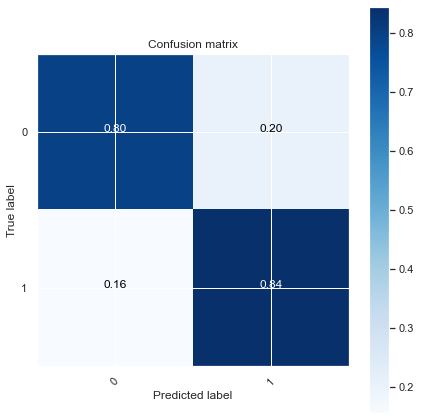

In [60]:
y_pred = logreg.predict(X_test)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

We observe a modest improvement in accuracy for the model with the data minimally transformed and scaled.
Model performance in terms of convergence has however however improved as previously the number of iterations before
convergence had to be increased to over 1000,000 which is no longer the case after the data has been scaled.


<div class="alert alert-block alert-info">
<b>Build Logistic Regression - Release 2</b>
</div>

We now perform feature selection in order to ascertain whether a smaller parsimonious model could be built with fewer
variables. As per the article by (Detrano et al., 1989) this could be useful from a practical perspective as not all
healthcare settings have all the variables to their disposal which necessitates the deployment of several complex
predictive models which is not practical from an operational perspective.

We will first perform correlation and regression tests on the data. These tests are best performed by considering
continuous and categoric variables separately due to the intrinsic difference in regression coefficient values
for these variables. We will then perform a few numeric methods on the full dataset and compare results.

We start by considering the continuous variables.

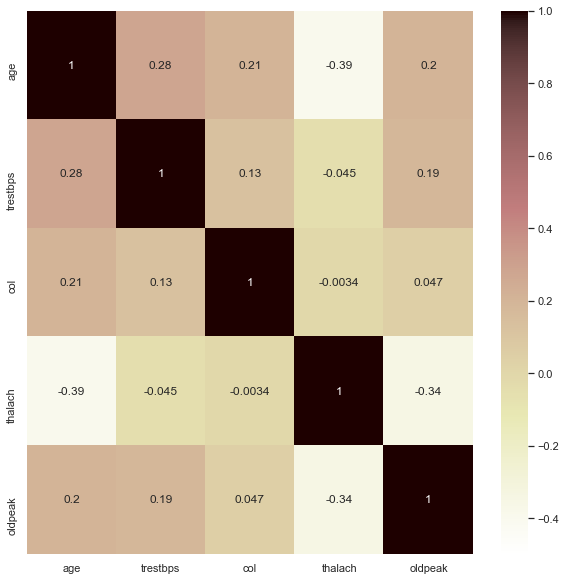

In [61]:
# Pearson correlation plot.
correlations = df_fin_con.corr()
# Plot correlation matrix
sns.set(font_scale=1);
fig = plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(correlations, annot=True, linewidths = 0, vmin=-.5, cmap='pink_r')

We see that there is a very strong inverse correlation between maximum heart rate and age. This makes sense as one's
maximum heart typically decreases with age. We also see that there is a strong positive correlation between maximum
heart rate and both cholesterol and resting blood pressure. This too makes sense as high blood pressure and cholesterol
are typically indications poor health which would result in lower maximum heart rate.
Another observation of interest is the strong correlation between cholesterol and the depression induced by exercise in
the ECG during exercise. These variables could make strong combined predictors for a next iteration of the model.
For now we will continue with the variables as is and focus on feature selection.

The first method we use is to compare the relative importance of logistic regression coefficient values for all our
continuous variables. Scikit-learn does not implement feature importance measures for logistic regression. We
therefore make use of the statsmodel libraries' implementation.

Optimization terminated successfully.
         Current function value: 0.509602
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.260     
Dependent Variable: y                AIC:              241.3593  
Date:               2020-10-23 20:10 BIC:              258.4841  
No. Observations:   227              Log-Likelihood:   -115.68   
Df Model:           4                LL-Null:          -156.37   
Df Residuals:       222              LLR p-value:      8.8664e-17
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
age            0.0147    0.0176   0.8334  0.4046  -0.0199   0.0493
trestbps       0.0160    0.0097   1.6516  0.0986  -0.0030   0.

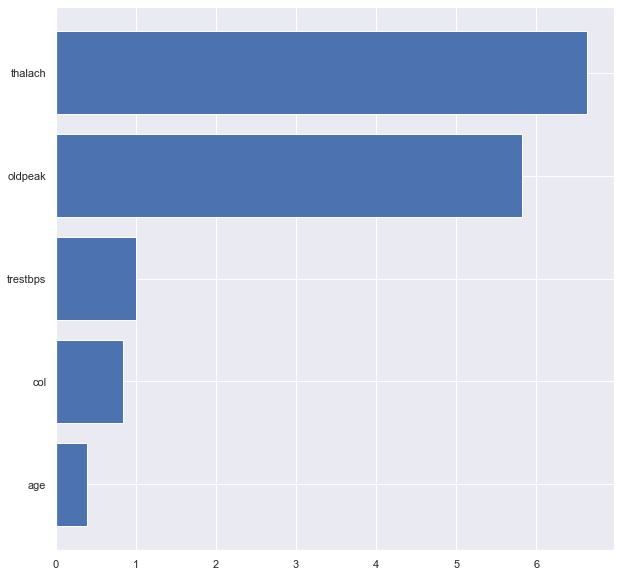

In [62]:
# Extract continuous and categorical variables for analysis.
X_con = df_fin_con.copy()
X_cat = df_fin_cat.loc[:,('sex', 'chest_pain_type', 'fasting_blood_sugar', 'restecg', 'exang', 'slope', 'ca', 'thal')]

X_train_con, X_test_con, y_train_con, y_test_con = train_test_split(X_con, y, random_state=0)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, random_state=0)

log_reg = sm.Logit(y_train_con, X_train_con)
log_result = log_reg.fit()

print(log_result.summary2())
features_con = np.array(names_con)
plot_feature_importance_log(fit = log_result, features = features_con)

From this analysis it can be seen that the only variables of significance are talach and oldpeak. The remainder of the
variables will be rejected based on their coefficient sizes.
I would have preferred a univariate comparison between all the features, but this is unfortunately quite cumbersome
to implement in a short space of time given the lack of support in scikit-learn.
Next we will however make use of scikit-learn's native feature extraction methods. The uni-variate Anova test
on continuous variables as implemented in SelectKBest function 'f_classif' will be used. Let's see what the results
are.

Feature:    thalach	Score:	11.81243
Feature:    oldpeak	Score:	11.80165
Feature:        age	Score:	3.80501
Feature:   trestbps	Score:	1.77980
Feature:        col	Score:	1.20672


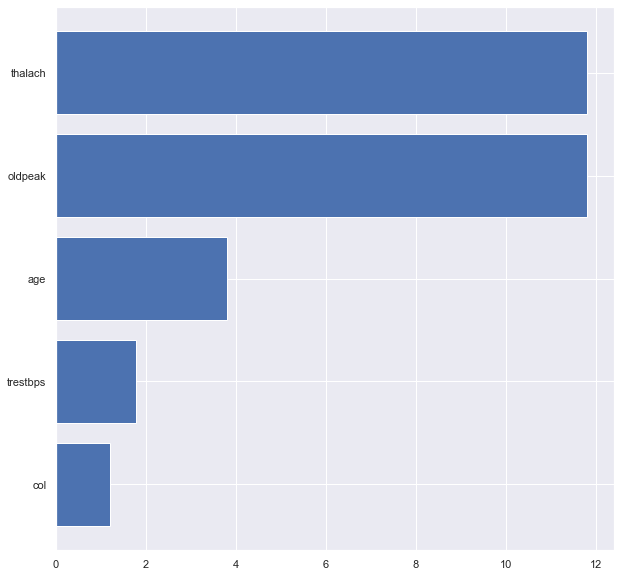

In [63]:
# Feature extraction set to retain all - we want to see scores for all variables.
test = SelectKBest(score_func=f_classif, k=5)
fit_kbest = test.fit(X_train_con, y_train_con)
features_kbest = np.array(X_con.columns)
plot_feature_importance(fit = fit_kbest, features = features_kbest)

We will now consider the categorical variables. Again the SelectKBest method will be used, but this time the
Chi-Squared function 'chi2' will be used. Let's see what the results are.

Feature:         ca	Score:	13.64256
Feature:       thal	Score:	12.12447
Feature:      exang	Score:	9.16471
Feature:         cp	Score:	3.09327
Feature:      slope	Score:	2.11834
Feature:        sex	Score:	1.14705
Feature:    restecg	Score:	0.87596
Feature:        fbs	Score:	0.06877


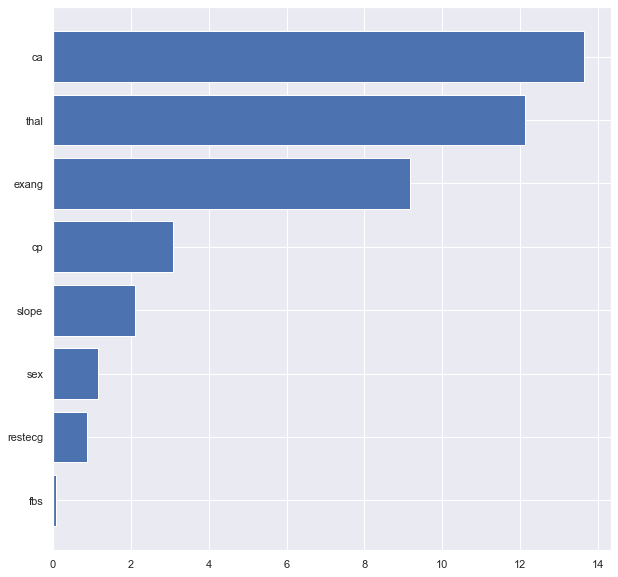

In [64]:
test_cat = SelectKBest(score_func=chi2, k='all')
fit_kbest_cat = test_cat.fit(X_train_cat, y_train_cat)
features_kbest_cat = np.array(X_cat.columns)
plot_feature_importance(fit = fit_kbest_cat, features = features_kbest_cat)

ca, tal and exang are all extremely strong predictors. chest_pain_type, slope and sex also contribute to the overall classification.
From this analysis the only non-significant variables are restecg and fasting_blood_sugar.

We now build our final model with the variables selected.

AUC: 0.8666666666666667


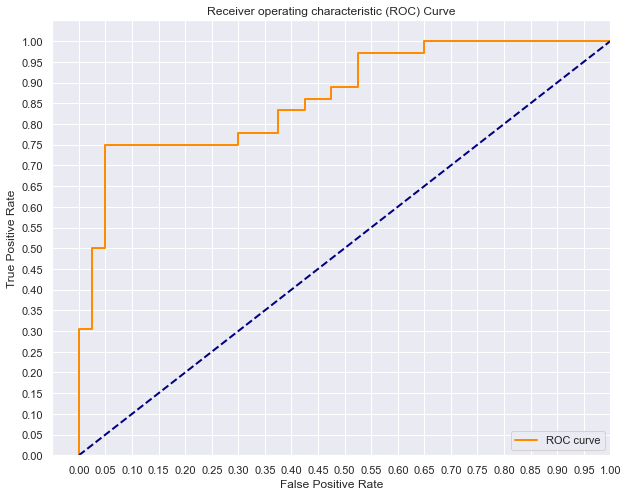

In [78]:
# Extract continuous and categorical variables for analysis.
X_fin_cat = df_fin_cat.loc[:,('sex', 'chest_pain_type', 'exang', 'slope', 'ca', 'thal')]
X_fin_con = df_fin_con.loc[:,('thalach', 'oldpeak')]
X_final = pd.concat([X_fin_cat, X_fin_con], axis=1)

X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(X_final, y, random_state=0)

# Final model
logfin = LogisticRegression(fit_intercept = False)

# Probability scores for test set
y_score_fin = logfin.fit(X_train_fin, y_train_fin).decision_function(X_test_fin)

# False positive Rate and true positive rate
fpr_roc, tpr_roc, thresholds = roc_curve(y_test_fin, y_score_fin)

plot_roc_curve(fpr = fpr_roc, tpr = tpr_roc)

Normalized confusion matrix

accuracy:			0.852  
precision:			0.821 
recall:				0.9

specificity:			0.804 
negative predictive value:	0.889

false positive rate:		0.196  
false negative rate:		0.1 
false discovery rate:		0.179


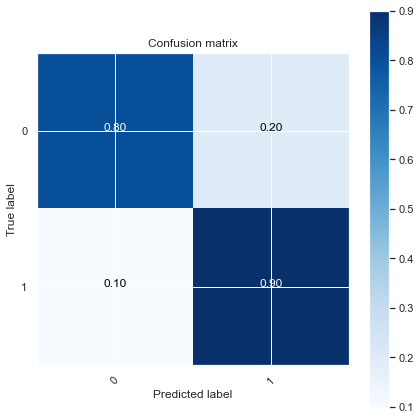

In [79]:
y_pred_fin = logfin.predict(X_test_fin)
# Accuracy before model parameter optimisation
cnf_matrix = confusion_matrix(y_pred_fin, y_test_fin)
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True)

The accuracy results indicate that even though 5 variables were dropped, the model accuracy did not reduce by
a significant amount. We can therefore confidently deploy this model with the knowledge that it is both robust and
accurate.


<div class="alert alert-block alert-info">
<b>Build Model 2 - Multi-Layer Perceptron</b>
</div>

We can now start building our model.
We begin with a simple Multi Layer Perceptron using scikit-learn to better understand the data.

### MSE before model optimisation

In [65]:
# Fit and check MSE before regularisation
reg = MLPClassifier(max_iter=50000, solver="adam", activation="tanh", hidden_layer_sizes=(5, 5), random_state=1)
reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

# Accuracy before model parameter optimisation
accuracy_score(y_pred,y_test)

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5), max_iter=50000,
              random_state=1)

0.8026315789473685

We now optimise the NN architecture.

In [66]:
# Optimise numbers of nodes on both layers
validation_scores = {}
print("Nodes |Validation")
print("      | score")

for hidden_layer_size in [(i,j) for i in range(3,6) for j in range(3,6)]:

    reg = MLPClassifier(max_iter=1000000, hidden_layer_sizes=hidden_layer_size, random_state=1)

    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2)
    validation_scores[hidden_layer_size] = score.mean()
    print(hidden_layer_size, ": %0.5f" % validation_scores[hidden_layer_size])

Nodes |Validation
      | score
(3, 3) : 0.76646
(3, 4) : 0.82821
(3, 5) : 0.79731
(4, 3) : 0.79743
(4, 4) : 0.78423
(4, 5) : 0.79739
(5, 3) : 0.77531
(5, 4) : 0.77527
(5, 5) : 0.78416


In [67]:
# Check scores
print("The highest validation score is: %0.4f" % max(validation_scores.values()))
optimal_hidden_layer_size = [name for name, score in validation_scores.items()
                              if score==max(validation_scores.values())][0]
print("This corresponds to nodes", optimal_hidden_layer_size )


The highest validation score is: 0.8282
This corresponds to nodes (3, 4)


Now we optimise neural network regularisation parameter

 alpha  |  Accuracy
0.13534 |  0.8105496040987424
0.22313 |  0.8017388604253998
0.36788 |  0.7973140816643378
0.60653 |  0.8017388604253998
1.00000 |  0.8061636391864617
1.64872 |  0.8106660456450862
2.71828 |  0.8107048594938674
4.48169 |  0.8107048594938674
7.38906 |  0.8282487191429901
12.18249 |  0.8546033224654557
20.08554 |  0.8414454277286136
33.11545 |  0.5462661077472442


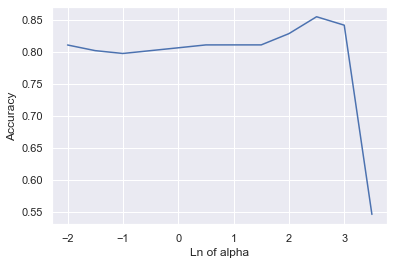

In [68]:
# Select range over which to find regularisation parameter - exponential used for even distribution of values
reg_par = [np.e**n for n in np.arange(-2,4,0.5)]

validation_scores = {}
print(" alpha  |  Accuracy")
for param in reg_par:
    reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh", hidden_layer_sizes=optimal_hidden_layer_size, alpha=param,
                        random_state=1)
    score = cross_val_score(estimator=reg, X=X_train, y=y_train, cv=2, scoring="accuracy")
    validation_scores[param] = score.mean()
    print("%0.5f |  %s" % (param, score.mean()))

# Plot the accuracy function against regularisation parameter
plt.plot([np.log(i) for i in validation_scores.keys()], list(validation_scores.values()));
plt.xlabel("Ln of alpha");
plt.ylabel("Accuracy");

The highest cross-validation accuracy score and hence the value to use for the `alpha` parameter is as follows.

In [69]:
max_score = ([np.log(name) for name, score in validation_scores.items() if score==max(validation_scores.values())][0])
# Find lowest value.
print("The highest accuracy score is: %s" % (max(validation_scores.values())))
print("This corresponds to regularisation parameter e**%s" % max_score)

The highest accuracy score is: 0.8546033224654557
This corresponds to regularisation parameter e**2.5


### MSE after regularisation

In [70]:
# Fit data with the best parameter
reg = MLPClassifier(max_iter=1000000, solver="adam", activation="tanh", hidden_layer_sizes=optimal_hidden_layer_size,
                    alpha=np.e**(2), random_state=1)

reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

# Accuracy after model parameter optimisation
accuracy_score(y_pred,y_test)

MLPClassifier(activation='tanh', alpha=7.3890560989306495,
              hidden_layer_sizes=(3, 4), max_iter=1000000, random_state=1)

0.8289473684210527

<div class="alert alert-block alert-info">
<b>Analysis of results</b>
</div>

### Plot response curves

In [71]:
# Create X_design_vec, which contains the median of each respective column
X_design = X.copy()
X_design_vec = pd.DataFrame(X_design.median()).transpose()
X_design_vec.head()

,age,sex,cp,trestbps,col,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,56.0,1.0,3.0,130.0,241.0,0.0,1.0,153.0,0.0,0.8,2.0,0.0,0.0


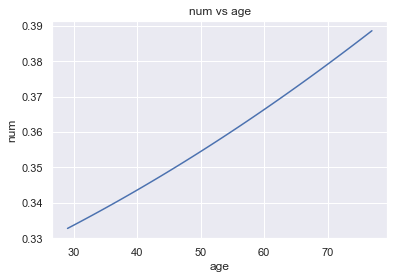

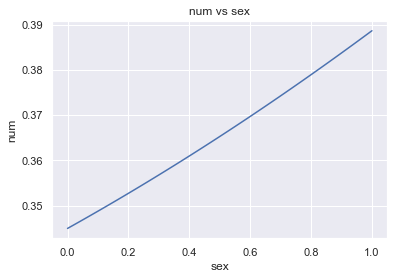

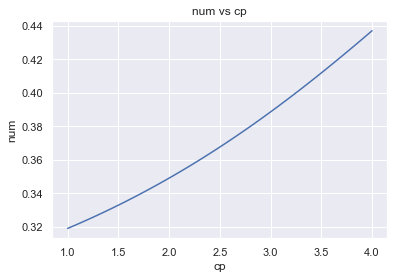

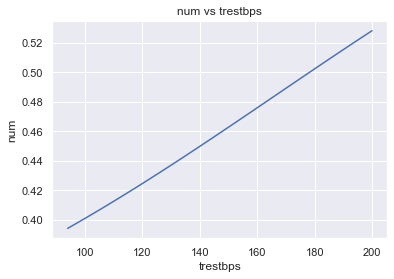

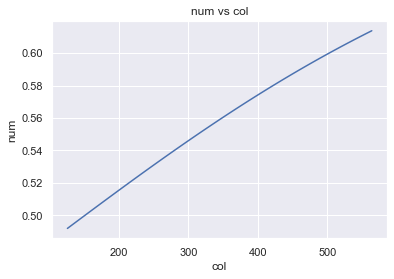

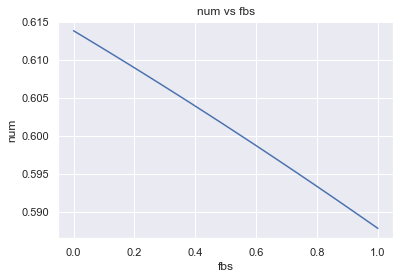

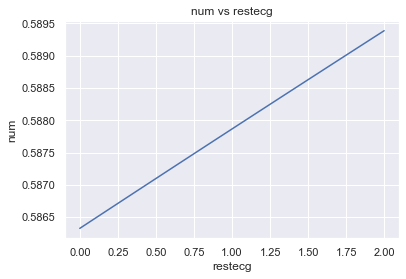

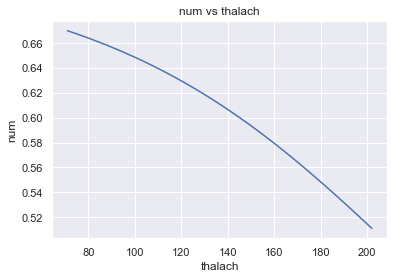

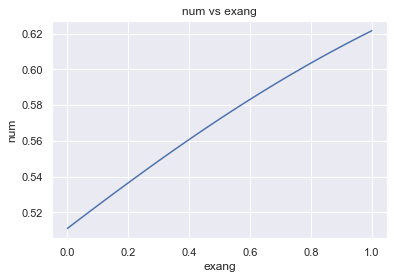

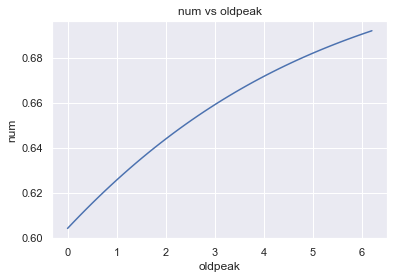

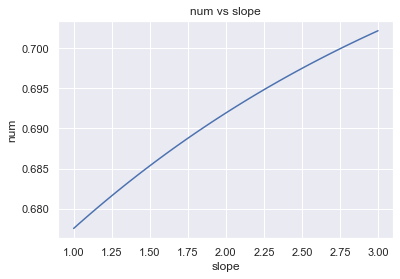

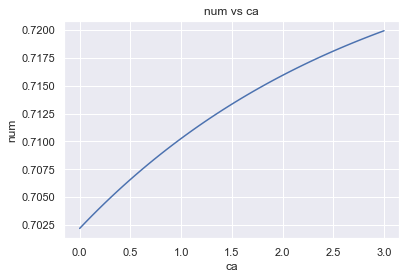

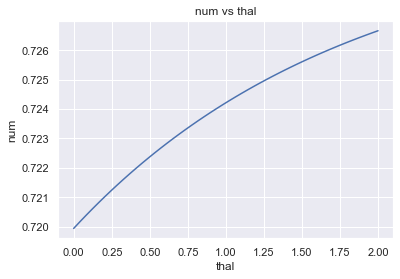

In [72]:
names_num = ('age', 'sex', 'chest_pain_type', 'trestbps', 'col', 'fasting_blood_sugar', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca',
             'thal')

for variable in names_num:
    # Set up a sequence for response variable to plot
    min_res = min(X.loc[:,variable])
    max_res = max(X.loc[:,variable])
    seq = np.linspace(start=min_res,stop=max_res,num=50)

    # Set up a list of moving resultants to plot
    to_predict = []
    for result in seq:
        X_design_vec.loc[0,variable] = result
        to_predict.append(X_design_vec.copy())

    # Convert back to dataframe
    to_predict = pd.concat(to_predict)

    # Scale and predict
    to_predict = scaler.transform(to_predict)
    predictions = reg.predict_proba(to_predict)

    # Plot
    _ = plt.plot(seq,predictions[:,1])
    _ = plt.xlabel(variable)
    _ = plt.ylabel("num")
    _ = plt.title("num vs " + variable)
    plt.show();

Our model is accurate enough to capture the directly proportionate relationship between several response variables
(in order of strength of association, based on response curve output):

- thal
- ca
- slope
- oldpeak
- exang
- restecg
- chol
- trestbps
- chest_pain_type
- sex
- age

and the inversely proportional relationship between:

- thalach
- fasting_blood_sugar

and the outcome of confirmed Coronary Artery Disease. This is a positive outcome, as it means the model as applied
to the validation dataset managed to capture the underlying signals in the data. We can therefore conclude that the
model generalises well and that its accuracy is sufficiently high for this model to be used based on the features
captured.

This makes sense if one takes into account that the first two variables:

- thal: Arteries found to be: 1. Normal 2. Reversible defect and 3. Fixed defect
- ca: Number of major vessels (0-3) coloured by fluoroscopy

are by nature close to the definition of Coronary Artery Disease itself.

### Accuracy analysis

In [73]:
accuracy = round(accuracy_score(y_pred=y_pred, y_true=y_test), 3)
precision = round(precision_score(y_pred=y_pred, y_true=y_test), 3)
recall = round(recall_score(y_pred=y_pred, y_true=y_test), 3)
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)

fp_label='false positive'
fp = cm[0][1]
fn_label='false negative'
fn = cm[1][0]
tp_label='true positive'
tp = cm[1][1]
tn_label='true negative'
tn = cm[0][0]

tpr_label = 'sensitivity'
tpr = round(tp/(tp+fn),3)
tnr_label = 'specificity'
tnr = round(tn/(tn+fp),3)
ppv_label = 'precision'
ppv = round(tp/(tp+fp),3)
npv_label = 'npv'
npv = round(tn/(tn+fn),3)
fpr_label = 'fpr'
fpr = round(fp/(fp+tn),3)
fnr_label = 'fnr'
fnr = round(fn/(tp+fn),3)
fdr_label = 'fdr'
fdr = round(fp/(tp+fp),3)

print('\naccuracy:\t\t\t{}  \nprecision:\t\t\t{} \nrecall:\t\t\t\t{}'.format(accuracy, precision, recall))
print('\nsensitivity:\t\t\t{}  \nspecificity:\t\t\t{} \nnegative predictive value:\t{}'.format(tpr, tnr, npv))
print('\nfalse positive rate:\t\t{}  \nfalse negative rate:\t\t{} \nfalse discovery rate:\t\t{}'.format(fpr, fnr, fdr))


accuracy:			0.829  
precision:			0.926 
recall:				0.694

sensitivity:			0.694  
specificity:			0.95 
negative predictive value:	0.776

false positive rate:		0.05  
false negative rate:		0.306 
false discovery rate:		0.074


15
Feature:        age	Score:	0.09639
Feature:        sex	Score:	0.00000
Feature:         cp	Score:	0.06617
Feature:   trestbps	Score:	0.00000
Feature:        col	Score:	0.04124
Feature:        fbs	Score:	0.00000
Feature:    restecg	Score:	0.00000
Feature:    thalach	Score:	0.00000
Feature:      exang	Score:	0.13927
Feature:    oldpeak	Score:	0.12318
Feature:      slope	Score:	0.00000
Feature:         ca	Score:	0.00410
Feature:       thal	Score:	0.52965


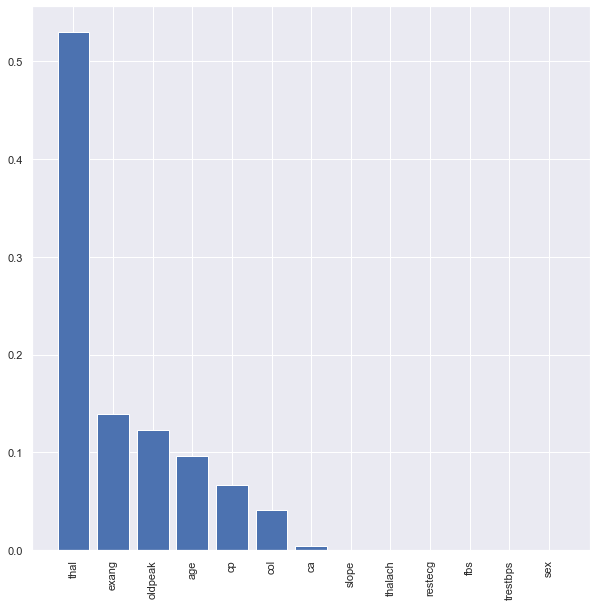

In [74]:
# Fit a Decision Tree to data
samples = [sample for sample in range(1,30)]
validation_scores = []
for sample in samples:
    classifier1 = DecisionTreeClassifier(random_state=1, min_samples_leaf=sample)
    score = cross_val_score(estimator=classifier1, X=X_train, y=y_train, cv=5)
    validation_scores.append(score.mean())

# Obtain the minimum leaf samples with the highest validation score
samples_optimum = samples[validation_scores.index(max(validation_scores))]
print(samples_optimum)

classifier2 = DecisionTreeClassifier(random_state=0, min_samples_leaf=samples_optimum)
classifier2.fit(X_train, y_train)

importances = np.array(classifier2.feature_importances_)
feature_list = np.array(X.columns)

# summarize feature importance
for i,v in enumerate(importances):
	print('Feature: %10s\tScore:\t%.5f' % (feature_list[i],v))
# plot feature importance
sorted_ID=np.array(np.argsort(importances)[::-1])
plt.figure(figsize=[10,10])
plt.xticks(rotation='vertical')
_ = plt.bar(feature_list[sorted_ID], importances[sorted_ID]);
plt.show();

# Not very convincing results, next we will look at random forests and logistic regression
# as means to detect feature importance.